<a href="https://colab.research.google.com/github/TacoRav4/Neural-Network-Music-Exploration/blob/main/Emergent_Tonal_Structure_from_a_Simple_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emergent Tonal Structure from a Simple Neural Network

# Importing packages

In [ ]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

SEED = 269
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Musical "vocabulary": pitch classes, chords, keys

## We will index pitch classes C = 0, C# = 1, ..., B = 11

- Chords: 24 total = 12 major triads + 12 minor triads
- Keys: 24 total = 12 major keys + 12 minor keys  

In [ ]:
PC_NAMES = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]

def chord_index(root_pc: int, quality: str) -> int:
  # quality: "maj" or "min"
  assert 0 <= root_pc <= 11
  assert quality in ["maj","min"]
  return root_pc if quality == "maj" else root_pc + 12

def key_index(tonic_pc: int, quality: str) -> int:
  # quality: "maj" or "min"
  assert 0 <= tonic_pc <= 11
  assert quality in ["maj","min"]
  return tonic_pc if quality == "maj" else tonic_pc + 12

def decode_key(k: int):
  tonic = k % 12
  mode = "maj" if k < 12 else "min"
  return PC_NAMES[tonic], mode

def decode_chord(c: int):
  root = c % 12
  qual = "maj" if c < 12 else "min"
  return PC_NAMES[root], qual

# Synthetic "exposure" dataset: diatonic triads sampled by key

### Major key diatonic triads (triads qualities):

- I maj, ii min, iii min, IV maj, vi min, vii°

### Minor key (natural minor-ish):
- i min, III maj, iv min, V min, VI maj, VII maj

### In this one, I will use a practical set:
- i, III, iv, v, VI, VII

### Major key diatonic triads (triads qualities)

In [ ]:
def major_key_triads_set(tonic_pc: int):
    # returns list of chord indices for diatonic triads (skip diminished)
    # scale degrees: 0,2,4,5,7,9 (I, ii, iii, IV, V, vi)
    roots = [(tonic_pc + x) % 12 for x in [0,2,4,5,7,9]]
    quals = ["maj","min","min","maj","maj","min"]
    return [chord_index(r,q) for r,q in zip(roots, quals)]



### Minor key (natural minor-ish):

In [ ]:
def minor_key_triad_set(tonic_pc: int):
    # natural minor-ish: i, III, iv, v, VI, VII
    roots = [(tonic_pc + x) % 12 for x in [0,3,5,7,8,10]]
    quals = ["min","maj","min","min","maj","maj"]
    return [chord_index(r,q) for r,q in zip(roots, quals)]

### key triads

In [ ]:
def key_triad_set(key_id: int):
    tonic = key_id % 12
    mode = "maj" if key_id < 12 else "min"
    return major_key_triads_set(tonic) if mode=="maj" else minor_key_triad_set(tonic)

### Weights for the 6 chords we are using
- We will emphasize tonic + dominant (+ subdominant)

In [ ]:
MAJ_WEIGHTS = np.array([0.28, 0.10, 0.08, 0.18, 0.26, 0.10])  # I, ii, iii, IV, V, vi
MIN_WEIGHTS = np.array([0.30, 0.12, 0.16, 0.14, 0.16, 0.12])  # i, III, iv, v, VI, VII

### Sample chords from our keys

In [ ]:
def sample_chord_from_key(key_id: int) -> int:
    triads = key_triad_set(key_id)
    w = MAJ_WEIGHTS if key_id < 12 else MIN_WEIGHTS
    return int(np.random.choice(triads, p=w / w.sum()))

### Create train data

In [ ]:
# Onehot encoding
def one_hot(n, idx):
    v = np.zeros(n, dtype=np.float32)
    v[idx] = 1.0
    return v

def make_dataset(n_samples=60000):
    X = np.zeros((n_samples, 24), dtype=np.float32)   # chord one-hot
    y = np.zeros((n_samples,), dtype=np.int64)        # key id

    for i in range(n_samples):
        k = np.random.randint(0, 24)
        c = sample_chord_from_key(k)
        X[i] = one_hot(24, c)
        y[i] = k
    return X, y

X, y = make_dataset(60000)

# split
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]
split = int(0.9 * len(X))
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]

X_train_t = torch.tensor(X_train).to(device)
y_train_t = torch.tensor(y_train).to(device)
X_val_t = torch.tensor(X_val).to(device)
y_val_t = torch.tensor(y_val).to(device)

X_train_t.shape, y_train_t.shape


(torch.Size([54000, 24]), torch.Size([54000]))

# # Creating Model: mini MLP
- Chord
- |
- Hidden
- |
- Key

In [ ]:
class ChordToKeyMLP(nn.Module):
  def __init__(self, in_dim=24, hid_dim=48, out_dim=24):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hid_dim)
        self.fc2 = nn.Linear(hid_dim, out_dim)

  def forward(self, x, return_hidden=False):
        h = F.relu(self.fc1(x))
        logits = self.fc2(h)
        if return_hidden:
            return logits, h
        return logits

model = ChordToKeyMLP(hid_dim = 48).to(device)
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)



# Training
- Due to the high ambiguity nature of musical chords, the accuracy is expected to be low.

In [ ]:
def accuracy(logits, y_true):
    preds = logits.argmax(dim=1)
    return (preds == y_true).float().mean().item()

def train(model, epochs=10, batch_size=256):
    n = X_train_t.shape[0]
    for ep in range(1, epochs+1):
        model.train()
        idx = torch.randperm(n, device=device)
        total_loss = 0.0

        for start in range(0, n, batch_size):
            batch = idx[start:start+batch_size]
            xb = X_train_t[batch]
            yb = y_train_t[batch]

            opt.zero_grad()
            logits = model(xb)
            loss = F.cross_entropy(logits, yb)
            loss.backward()
            opt.step()

            total_loss += loss.item() * xb.size(0)

        model.eval()
        with torch.no_grad():
            val_logits = model(X_val_t)
            val_loss = F.cross_entropy(val_logits, y_val_t).item()
            val_acc = accuracy(val_logits, y_val_t)

        print(f"Epoch {ep:02d} | train loss {total_loss/n:.4f} | val loss {val_loss:.4f} | val acc {val_acc:.3f}")

train(model, epochs=12)


Epoch 01 | train loss 2.8535 | val loss 2.2754 | val acc 0.288
Epoch 02 | train loss 1.9776 | val loss 1.8405 | val acc 0.289
Epoch 03 | train loss 1.7998 | val loss 1.7670 | val acc 0.289
Epoch 04 | train loss 1.7563 | val loss 1.7425 | val acc 0.285
Epoch 05 | train loss 1.7401 | val loss 1.7327 | val acc 0.286
Epoch 06 | train loss 1.7324 | val loss 1.7269 | val acc 0.283
Epoch 07 | train loss 1.7281 | val loss 1.7238 | val acc 0.290
Epoch 08 | train loss 1.7252 | val loss 1.7193 | val acc 0.285
Epoch 09 | train loss 1.7233 | val loss 1.7187 | val acc 0.283
Epoch 10 | train loss 1.7222 | val loss 1.7172 | val acc 0.286
Epoch 11 | train loss 1.7213 | val loss 1.7162 | val acc 0.286
Epoch 12 | train loss 1.7203 | val loss 1.7167 | val acc 0.287


# Cognitive evaluations

### Circle of fifths distance + key-induction gradient
- Setting distance on the circle of fifths
- Fpr a tonic pc, its position on circle of fifths can be mapped by repeated +7 moves

In [ ]:
# map tonic pc -> circle-of-fifths index (0..11) relative to C=0

# brute-force solve
FIFTH_POS = {}
for k in range(12):
    FIFTH_POS[(7*k) % 12] = k # position(pc) = k such that (7*k) % 12 == pc

def fifth_distance(pc_a, pc_b):
    a = FIFTH_POS[pc_a]
    b = FIFTH_POS[pc_b]
    d = abs(a - b)
    return min(d, 12 - d)

def key_tonic_pc(key_id):
    return key_id % 12


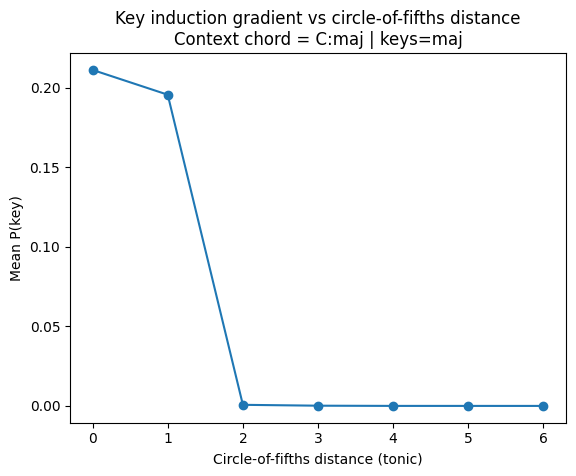

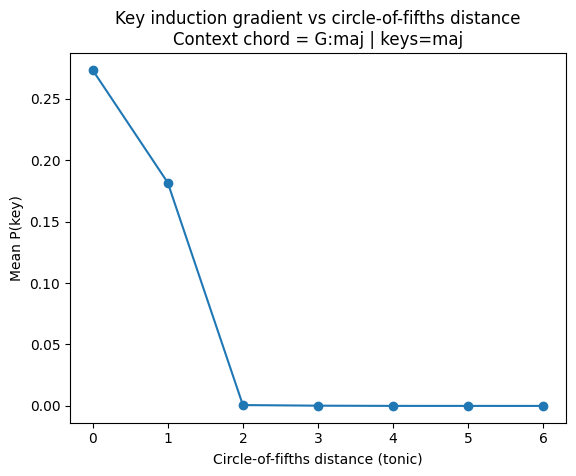

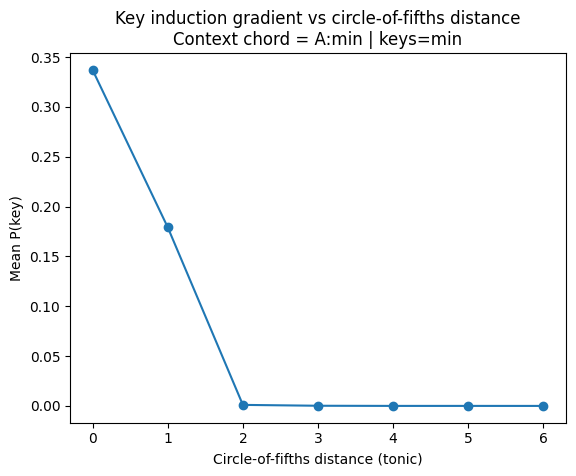

In [ ]:
# Picking a "context chord".
# Getting model's output probilities over 24 keys
# Plotting mean probability by fifth-distance (only major keys for now)

def key_probs_for_chord(chord_id: int):
    x = torch.tensor(one_hot(24, chord_id)).to(device).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1).squeeze(0).cpu().numpy()
    return probs  # shape (24,)

def plot_key_induction_gradient(context_chord_id: int, mode="maj"):
    probs = key_probs_for_chord(context_chord_id)

    # choose which key set to analyze
    key_ids = list(range(12)) if mode=="maj" else list(range(12,24))
    context_root = decode_chord(context_chord_id)[0]
    # use chord root as reference for "expected" key center (not perfect, but reasonable)
    chord_root_pc = context_chord_id % 12

    dist_to_probs = {d: [] for d in range(7)}  # distances 0..6
    for k in key_ids:
        d = fifth_distance(key_tonic_pc(k), chord_root_pc)
        dist_to_probs[d].append(probs[k])

    ds = sorted(dist_to_probs.keys())
    means = [np.mean(dist_to_probs[d]) for d in ds]

    plt.figure()
    plt.plot(ds, means, marker="o")
    chord_name = f"{decode_chord(context_chord_id)[0]}:{decode_chord(context_chord_id)[1]}"
    plt.title(f"Key induction gradient vs circle-of-fifths distance\nContext chord = {chord_name} | keys={mode}")
    plt.xlabel("Circle-of-fifths distance (tonic)")
    plt.ylabel("Mean P(key)")
    plt.show()

# Let's see C, G, A chord
plot_key_induction_gradient(chord_index(0,"maj"), mode="maj")   # C major chord
plot_key_induction_gradient(chord_index(7,"maj"), mode="maj")   # G major chord
plot_key_induction_gradient(chord_index(9,"min"), mode="min")   # A minor chord

# Tracking key(s) over a chord sequency (with context accumulation)

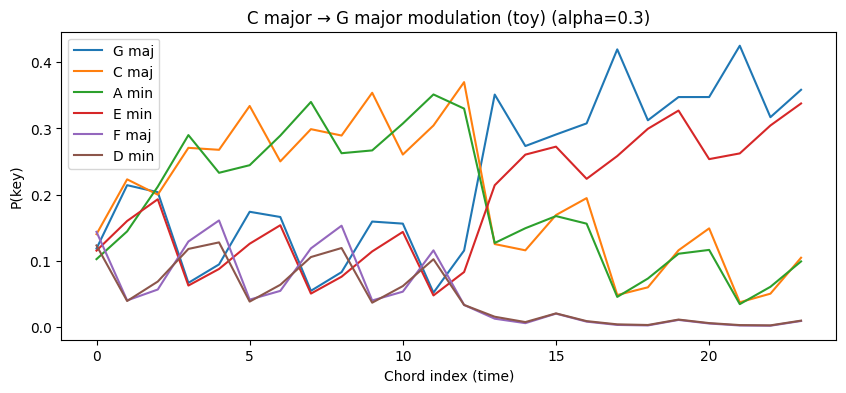

Chord sequence:
C:maj | G:maj | A:min | F:maj | C:maj | G:maj | A:min | F:maj | C:maj | G:maj | A:min | F:maj | G:maj | D:maj | E:min | C:maj | G:maj | D:maj | E:min | C:maj | G:maj | D:maj | E:min | C:maj


In [ ]:
@torch.no_grad()
def sequence_key_tracking(chord_ids, alpha=0.35):
    """
    alpha: context update rate (smaller = more memory)
    Returns key probability per timestep: shape (T, 24)
    """
    model.eval()
    W1, b1 = model.fc1.weight, model.fc1.bias
    W2, b2 = model.fc2.weight, model.fc2.bias

    h = torch.zeros((1, W1.shape[0]), device=device) # hidden dim
    all_probs = []

    for c in chord_ids:
        x = torch.tensor(one_hot(24, c), device=device).unsqueeze(0)
        h_in = F.relu(F.linear(x, W1, b1)) # instantaneous hidden
        h = (1-alpha) * h + alpha * h_in # leaky integrate
        logits = F.linear(h, W2, b2)
        probs = F.softmax(logits, dim=1).squeeze(0).cpu().numpy()
        all_probs.append(probs)

    return np.stack(all_probs, axis=0)

def make_progression_in_key(tonic_pc, mode="maj", length=16):
    # simple I–V–vi–IV-ish for major; i–VII–VI–VII-ish for minor (toy)
    if mode == "maj":
        I = chord_index(tonic_pc, "maj")
        V = chord_index((tonic_pc + 7) % 12, "maj")
        vi = chord_index((tonic_pc + 9) % 12, "min")
        IV = chord_index((tonic_pc + 5) % 12, "maj")
        prog = [I, V, vi, IV]
    else:
        i = chord_index(tonic_pc, "min")
        VII = chord_index((tonic_pc + 10) % 12, "maj")
        VI = chord_index((tonic_pc + 8) % 12, "maj")
        v = chord_index((tonic_pc + 7) % 12, "min")
        prog = [i, VII, VI, v]
    out = (prog * ((length + len(prog) - 1)//len(prog)))[:length]
    return out

def plot_key_tracking(chord_ids, alpha=0.35, topk=5, title="Key tracking"):
    probs_t = sequence_key_tracking(chord_ids, alpha=alpha)
    T = probs_t.shape[0]

    # pick top keys by average prob
    avg = probs_t.mean(axis=0)
    keys = np.argsort(-avg)[:topk]

    plt.figure(figsize=(10,4))
    for k in keys:
        plt.plot(range(T), probs_t[:, k], label=f"{decode_key(k)[0]} {decode_key(k)[1]}")
    plt.title(f"{title} (alpha={alpha})")
    plt.xlabel("Chord index (time)")
    plt.ylabel("P(key)")
    plt.legend()
    plt.show()

    # print chord names for reference
    print("Chord sequence:")
    print(" | ".join([f"{decode_chord(c)[0]}:{decode_chord(c)[1]}" for c in chord_ids]))

# Example: C major then modulate to G major
seq1 = make_progression_in_key(tonic_pc=0, mode="maj", length=12) # C major-ish
seq2 = make_progression_in_key(tonic_pc=7, mode="maj", length=12) # G major-ish
seq = seq1 + seq2

plot_key_tracking(seq, alpha=0.30, topk=6, title="C major → G major modulation (toy)")


# Hidden-state geomery (PCA + t-SNE)

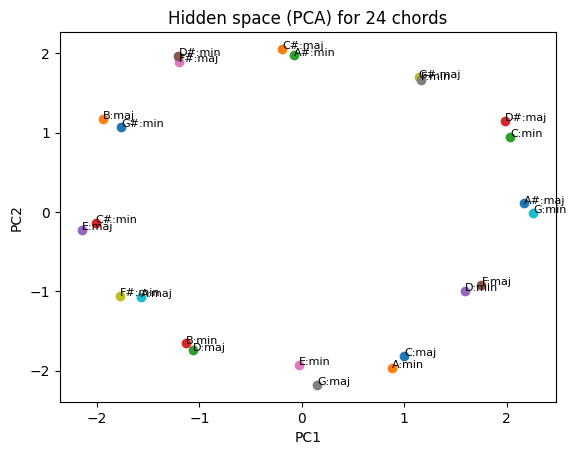

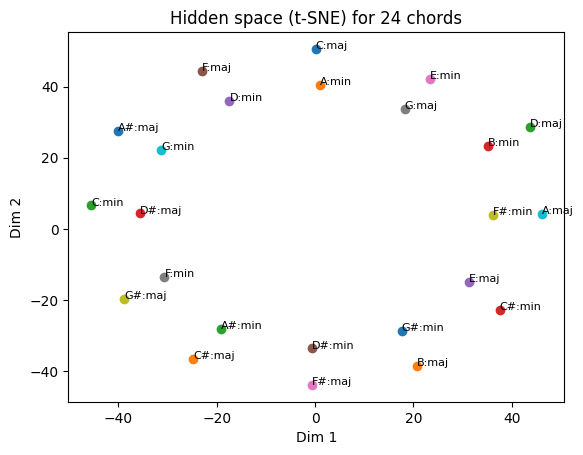

In [ ]:
# Embed each chord (24 of them)
# Collect hidden activations
# Visualize

@torch.no_grad()
def hidden_vectors_for_all_chords():
    model.eval()
    H = []
    labels = []
    for c in range(24):
        x = torch.tensor(one_hot(24, c), device=device).unsqueeze(0)
        logits, h = model(x, return_hidden=True)
        H.append(h.squeeze(0).cpu().numpy())
        labels.append(c)
    return np.stack(H, axis=0), labels

H, chord_labels = hidden_vectors_for_all_chords()

def plot_pca_hidden(H):
    Z = PCA(n_components=2).fit_transform(H)
    plt.figure()
    for i, c in enumerate(range(24)):
        name = f"{decode_chord(c)[0]}:{decode_chord(c)[1]}"
        plt.scatter(Z[i,0], Z[i,1])
        plt.text(Z[i,0], Z[i,1], name, fontsize=8)
    plt.title("Hidden space (PCA) for 24 chords")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

plot_pca_hidden(H)

def plot_tsne_hidden(H):
    Z = TSNE(n_components=2, perplexity=8, random_state=SEED, init="random", learning_rate="auto").fit_transform(H)
    plt.figure()
    for i, c in enumerate(range(24)):
        name = f"{decode_chord(c)[0]}:{decode_chord(c)[1]}"
        plt.scatter(Z[i,0], Z[i,1])
        plt.text(Z[i,0], Z[i,1], name, fontsize=8)
    plt.title("Hidden space (t-SNE) for 24 chords")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.show()

plot_tsne_hidden(H)
